In [5]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import numpy as np
from numpy import pi

In [28]:
"""Shorのアルゴリズム
簡略化とイメージしやすさのため、N=15, x=2の場合のみ機能する
"""
def cmul_mod15(n_eigstate, repetitions, count):
    """制御Uゲート
    Uと同じ働きをする量子回路を作成してからユニタリゲートに変換し、さらにそれを制御Uゲートに変換したものを返す
    """
    U = QuantumCircuit(n_eigstate, name="U^2^{}".format(count))
    for i in range(repetitions):
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    U = U.to_gate()
    c_U = U.control(1)
    return c_U

"""逆量子フーリエ変換"""
def qft_rotate_single_inv(qc, i, n):
    if n == 0:
        return qc
    for q in range(0, i):
        qc.cp(-pi/2**(i-q), q, i)
    qc.h(i)

def qft_dagger(n):
    """QFT†"""
    qft_qc = QuantumCircuit(n, name="QFT†")
    for i in range(n//2):
        qft_qc.swap(i, n-(i+1))
    for i in range(n):
        qft_rotate_single_inv(qft_qc, i, n)
    return qft_qc

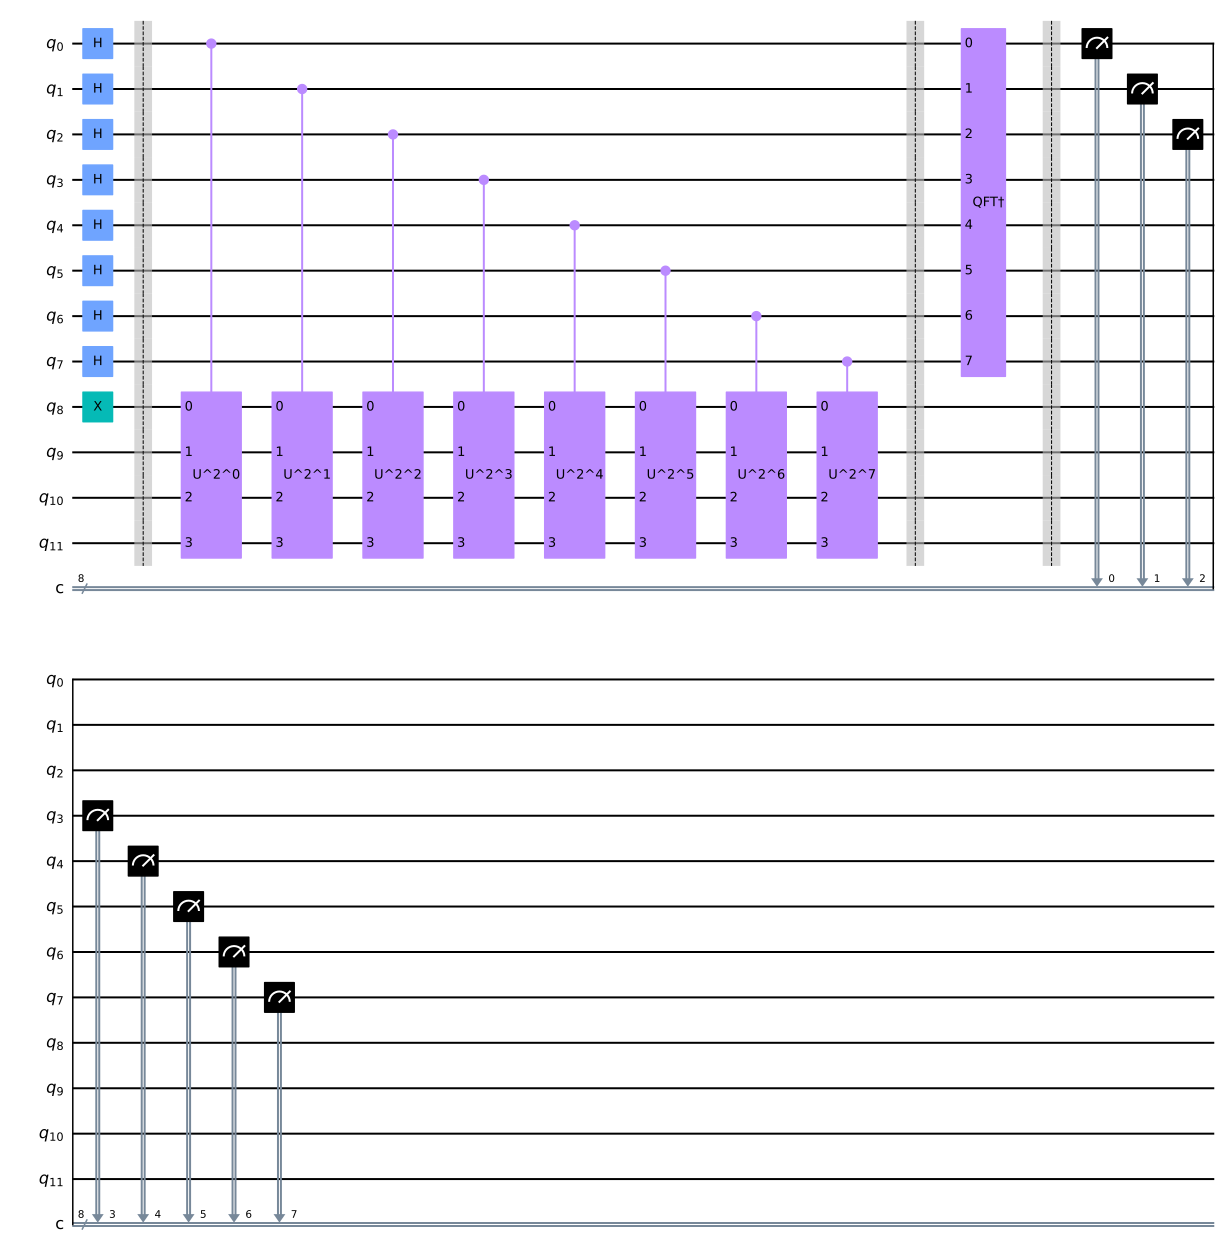

In [29]:
"""量子回路の作成
"""
n_encode = 8  # 求めたい固有値の位相角をエンコードする量子ビット数
n_eigstate = 4  # 固有状態の量子ビット数

qc = QuantumCircuit(n_encode + n_eigstate, n_encode)

# 初期化と重ね合わせ状態を作る
for i in range(n_encode):
    qc.h(i)
qc.x(n_encode)
qc.barrier()

# repetitions
repetitions = 1
for count in range(n_encode):
    qc.append(cmul_mod15(n_eigstate, repetitions, count), [count]+[8, 9, 10, 11])
    repetitions *= 2
qc.barrier()

# 逆QFT
qft_qc = qft_dagger(n_encode)
qc.append(qft_qc, range(n_encode))
qc.barrier()

# 測定
for i in range(n_encode):
    qc.measure(i, i)

qc.draw()

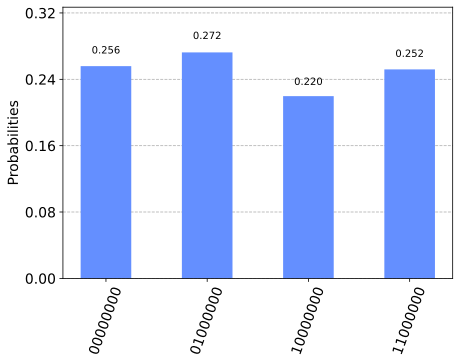

In [34]:
"""実行
今回は、
|1> = 1/2(|u0>+|u1>+|u2>+|u3>)
に対して量子位相推定を行った。4通りの固有状態の固有値が確率的に推定された。
"""
backend = Aer.get_backend("aer_simulator")
shots = 1024
result = execute(qc, backend=backend, shots=shots).result()
counts = result.get_counts()
plot_histogram(counts)